This guide covers training, evaluation, and prediction (inference) models in TensorFlow 2.0 in two broad situations:

- When using built-in APIs for training & validation (such as `model.fit()`, `model.evaluate()`, `model.predict()`). This is covered in the section **"Using build-in training & evaluation loops"**.
- When writing custom loops from scratch using eager execution and the `GradientTape` object. This is covered in the section **"Writing your own training & evaluation loops from scratch"**.

In general, whether you are using built-in loops or writing your own, model training & evaluation works strictly in the same way across every kind of Keras model -- Sequential models, models built with the Functional API, and models written from scratch via model subclassing.

This guide doesn't cover distributed training.

## Setup

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np

tf.keras.backend.clear_session()  # For easy reset of notebook state.

## Part I: Using build-in training & evaluation loops

When passing data to the built-in training loops of a model, you should either use **Numpy arrays** (if your data is small and fits in memory) or **tf.data Dataset** objects. In the ndex few paragraphs, we'll use the MNIST dataset as Numpy arrays, in order to demonstrate how to use optimizers, losses, and metrics.

### API overview: a first end-to-end example

Let's consider the following model (here, we build in with the Functional API, but it could be a Sequential model or a subclassed model as well):

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what the typical ent-to-end workflow looks like, consisting of training, validation on a holdout set generated from the original training data, and finally evaluation on the test data:

Load a toy dataset for the sake of this example

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are Numpy arrays)
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test =y_test.astype('float32')

# Reverse 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

Specify the training configuration (optimizer, loss, metrics)

In [4]:
model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # List of metrics to monitor
              metrics=['sparse_categorical_accuracy'])

Train the model by slicing the data into "batches" of size "batch_size", and repeatedly iterating over the entire dataset for a given number of "epochs"

In [5]:
print('# Fit model on training data')
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=3,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(x_val, y_val))

print('\nhistory dict:', history.history)

# Fit model on training data
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 5s 106us/sample - loss: 1.6044 - sparse_categorical_accuracy: 0.8797 - val_loss: 1.5334 - val_sparse_categorical_accuracy: 0.9340
Epoch 2/3
50000/50000 [==============================] - 6s 116us/sample - loss: 1.5302 - sparse_categorical_accuracy: 0.9363 - val_loss: 1.5217 - val_sparse_categorical_accuracy: 0.9433
Epoch 3/3
50000/50000 [==============================] - 6s 122us/sample - loss: 1.5161 - sparse_categorical_accuracy: 0.9477 - val_loss: 1.5163 - val_sparse_categorical_accuracy: 0.9472

history dict: {'loss': [1.6043912689995765, 1.5301881868028642, 1.516144707517624], 'sparse_categorical_accuracy': [0.87972, 0.93628, 0.94768], 'val_loss': [1.5334096962451935, 1.5216941216111184, 1.5162806903123855], 'val_sparse_categorical_accuracy': [0.934, 0.9433, 0.9472]}


The returned "history" object holds a record of the loss values and metric values during training

In [6]:
# Evaluate the model on the test data using 'evaluate'
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using 'predict'
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
10000/10000 [==============================] - 0s 32us/sample - loss: 1.5206 - sparse_categorical_accuracy: 0.9434
test loss, test acc: [1.5205532900094987, 0.9434]

# Generate predictions for 3 samples
predictions shape: (3, 10)


### Specifying a loss, metrics, and an optimizer
To train a model with `fit`, you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.

You pass these to the model as arguments to the `compile()` method:

The `metrics` argument should be a list -- you model can have any number of metrics.

If your model has multiple outputs, you can specify different losses and metrics for each output, and you can modulate the contribution of each output to the total loss of the model. You will find more details about this in the section **"Passing data to multi-input, multi-output models"**.

In [9]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

For later reuse, let's put our model definition and compile step in functions; we will call them several times across different examples in this guide.

In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name='digits')
    x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = layers.Dense(10, name='predictions')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['sparse_categorical_accuracy'])
    return model

#### Many built-in optimizers, losses, and metrics are available
In general, you won't have to create from scratch your own losses, metrics, or optimizers, because what you need is likely already part of the Keras API:

Optimizers:
- `SGD()` (with or without momentum)
- `RMSprop()`
- `Adam()`
- etc.

Losses:
- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- etc.

Metrics:
- `AUC()`
- `Precision()`
- `Recall()`
- etc.

#### Custom losses
There are two ways to provide custom losses with Keras. The first example creates a function that accepts inputs `y_true` and `y_pred`. The following example shows a loss function that computes the average absolute error between the real data and the predictions:

In [12]:
def basic_loss_function(y_true, y_pred):
    return tf.math.reduce_mean(tf.abs(y_true - y_pred))

model.compile(optimizer=keras.optimizers.Adam(),
              loss=basic_loss_function)

model.fit(x_train, y_train, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 82us/sample - loss: 4.3686
Epoch 2/3
50000/50000 [==============================] - 4s 80us/sample - loss: 4.3686
Epoch 3/3
50000/50000 [==============================] - 4s 79us/sample - loss: 4.3686


If you need a loss function that takes in parameters beside `y_true` and `y_pred`, you can subclass the `tf.keras.losses.Loss` class and implement the following two methods:

- `__init__(self)` —Accept parameters to pass during the call of your loss function
- `call(self, y_true, y_pred)` —Use the targets (y_true) and the model predictions (y_pred) to compute the model's loss

Parameters passed into `__init__()` can be used during `call()` when calculating loss.

The following example shows how to implement a `WeightedCrossEntropy` loss function that calculates a `BinaryCrossEntropy` loss, where the loss of a certain class or the whole function can be modified by a scalar.

In [13]:
class WeightedBinaryCrossEntropy(keras.losses.Loss):
    """
    Args:
      pos_weight: Scalar to affect the positive labels of the loss function.
      weight: Scalar to affect the entirety of the loss function.
      from_logits: Whether to compute loss from logits or the probability.
      reduction: Type of tf.keras.losses.Reduction to apply to loss.
      name: Name of the loss function.
    """
    def __init__(self, pos_weight, weight, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_binary_crossentropy'):
        super().__init__(reduction=reduction, name=name)
        self.pos_weight = pos_weight
        self.weight = weight
        self.from_logits = from_logits
        
    def call(self, y_true, y_pred):
        ce = tf.losses.binary_crossentropy(
            y_true, y_pred, from_logits=self.from_logits)[:,None]
        ce = self.weight * (ce*(1-y_true) + self.pos_weight*ce*(y_true))
        return ce

Binary loss but the dataset has 10 classes, so apply the loss to the dataset as if it were making an independent binary prediction for each class. To do that, start by creating one-hot vectors from the class indices:

In [16]:
one_hot_y_train = tf.one_hot(y_train.astype(np.int32), depth=10)

In [21]:
y_train[:2]

array([5., 0.], dtype=float32)

In [22]:
one_hot_y_train[:2]

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

Now use those hone-hots, and the custom loss to train a model:

In [23]:
model = get_uncompiled_model()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=WeightedBinaryCrossEntropy(
        pos_weight=0.5, weight=2, from_logits=True)
)

model.fit(x_train, one_hot_y_train, batch_size=64, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 89us/sample - loss: 0.1672
Epoch 2/5
50000/50000 [==============================] - 3s 66us/sample - loss: 0.0655
Epoch 3/5
50000/50000 [==============================] - 4s 86us/sample - loss: 0.0472
Epoch 4/5
50000/50000 [==============================] - 4s 78us/sample - loss: 0.0376
Epoch 5/5
50000/50000 [==============================] - 3s 67us/sample - loss: 0.0313


#### Custom metrics
If you need a metric that isn't part of the API, you can easily create custom metrics by subclassing the `Metric` class.  
You will need to implement 4 methods:
- `__init__(self)`, in which you will create state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`, which uses the targets `y_true` and the model predictions `y_pred` to update the state variables.
- `result(self)`, which uses the state variables to compute the final results.
- `reset_states(self)`, which reinitializes the state of the metric

State update and results computation are kept separate (in `update_state()` and `result()`, respectively) because in some cases, results computation might be very expensive, and would only be done periodically.

Here's simple example showing how to implement a `CategoricalTruePositives` metric, that counts how many samples where correctly classified as belonging to a given class:

In [40]:
class CategoricalTruePositives(keras.metrics.Metric):
    
    def __init__(self, name='categorical_true_positives', **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float64')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float64')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
        
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

In [41]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[CategoricalTruePositives()])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 5s 94us/sample - loss: 0.0425 - categorical_true_positives: 49373.0000
Epoch 2/3
50000/50000 [==============================] - 4s 71us/sample - loss: 0.0371 - categorical_true_positives: 49440.0000
Epoch 3/3
50000/50000 [==============================] - 4s 83us/sample - loss: 0.0320 - categorical_true_positives: 49516.0000


#### Handling losses and metrics that don't fit the standard signature
The overwhelming majority of losses and metrics can be computed from `y_ture` and `y_pred`, where `y_pred` is an output of your model. But not all of them. For instance, a regularization loss may only require the activation of a layer (there are no targets in this case), and this activation may not be a model output.

In such cases, you can call `self.add_loss(loss_value)` from inside the `call` method of a custom layer. Here's a simple example that adds activity regularization (note that activity regularization is built-in in all Keras layers -- this layer is just for the sake of providing a concrete example):

In [42]:
class ActivityRegularizationLayer(layers.Layer):
    
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.
    
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 85us/sample - loss: 2.4903
Epoch 2/3
50000/50000 [==============================] - 4s 74us/sample - loss: 2.3014
Epoch 3/3
50000/50000 [==============================] - 3s 63us/sample - loss: 2.3013


You can do the same for logging metric values:

In [43]:
class MetricLoggingLayer(layers.Layer):
    
    def call(self, inputs):
        # The 'aggregation' argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(keras.backend.std(inputs),
                        name='std_of_activation',
                        aggregation='mean')
        return inputs  # Pass-through layer.
    
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 80us/sample - loss: 0.3295 - std_of_activation: 0.9554
Epoch 2/3
50000/50000 [==============================] - 5s 98us/sample - loss: 0.1559 - std_of_activation: 1.0045
Epoch 3/3
50000/50000 [==============================] - 4s 81us/sample - loss: 0.1151 - std_of_activation: 1.0283


In the `Functional API`, you can also call `model.add_loss(loss_tensor)`, or `model.add_metric(metric_tensor, name, aggregation)`.

Here's a simple example:

In [44]:
inputs = keras.Input(shape=(784,), name='digits')
x1 = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x2 = layers.Dense(64, activation='relu', name='dense_2')(x1)
outputs = layers.Dense(10, name='predictions')(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1),
                 name='std_of_activation',
                 aggregation='mean')

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 5s 102us/sample - loss: 2.4570 - std_of_activation: 0.0017
Epoch 2/3
50000/50000 [==============================] - 5s 103us/sample - loss: 2.3014 - std_of_activation: 8.5281e-06
Epoch 3/3
50000/50000 [==============================] - 5s 96us/sample - loss: 2.3013 - std_of_activation: 3.9881e-07


#### Automatically setting apart a validation holdout set
In the first end-to-end example you saw, we used the `validation_data` argument to pass a tuple of Numpy arrays `(x_val, y_val)` to the model for evaluating a validation loss and validation metrics at the end of each epoch.

Here's another option: the argument `validation_split` allows you to automatically reserve part of your training data for validation. The argument value represents the fraction of the data to be reserved for validation, so it should be set to a number higher than 0 and lower than 1. For instance, `validation_split=0.2` means "use 20% of the data for validation", and `validation_split=0.6` means "use 60% of the data for validation".

The way the validation is computed is by *taking the last x% samples* of the arrays received by the `fit` call, before any shuffling.

You can only use `validation_split` when training with Numpy data.

In [66]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1, steps_per_epoch=10)

Train on 40000 samples, validate on 10000 samples
  640/40000 [..............................] - ETA: 1:02 - loss: 1.9767 - sparse_categorical_accuracy: 0.3875 - val_loss: 1.5407 - val_sparse_categorical_accuracy: 0.6007

### Training & evaluation from tf.data.Datasets
In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers, and you've seen how to use the `validation_data` and `validation_split` arguments in `fit`, when your data is passed as Numpy arrays.

Let's now take a look at the case where your data comes in the form of a tf.data Dataset.

The tf.data API is a set of utilities in TensorFlow 2.0 for loading and preprocessing data in a way that's fast and scalable.

For a complete guide about creating Datasets, see the `tf.data documentation`.

You can pass a Dataset instance directly to the methods `fit()`, `evaluate()`, and `predict()`:

In [51]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print('\n# Evaluate')
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Train for 782 steps
Epoch 1/3
782/782 [==============================] - 4s 5ms/step - loss: 0.3303 - sparse_categorical_accuracy: 0.9067
Epoch 2/3
782/782 [==============================] - 5s 6ms/step - loss: 0.1587 - sparse_categorical_accuracy: 0.9536
Epoch 3/3
782/782 [==============================] - 5s 7ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9648

# Evaluate
157/157 [==============================] - 1s 5ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9632


{'loss': 0.12378468397800324, 'sparse_categorical_accuracy': 0.9632}

Note that the Dataset is reset at the end of each epoch, so it can be reused of the next epoch.

If you want to run training only on a specific number of batches from this Dataset, you can pass the `steps_per_epoch` argument, which specifies how many training steps the model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep drawing the next batches. The dataset will eventually run out of data (unless it is an infinitely-looping dataset).

In [67]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset.take(100), epochs=3)

Train for 100 steps
Epoch 1/3
100/100 [==============================] - 1s 8ms/step - loss: 0.7772 - sparse_categorical_accuracy: 0.7909
Epoch 2/3
100/100 [==============================] - 1s 6ms/step - loss: 0.3151 - sparse_categorical_accuracy: 0.9142
Epoch 3/3
100/100 [==============================] - 1s 5ms/step - loss: 0.2345 - sparse_categorical_accuracy: 0.9309


#### Using a validation dataset
You can pass a Dataset instance as the `validation_data` argument in `fit`:

In [68]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Train for 782 steps, validate for 157 steps
Epoch 1/3
782/782 [==============================] - 5s 7ms/step - loss: 0.3384 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.1779 - val_sparse_categorical_accuracy: 0.9512
Epoch 2/3
782/782 [==============================] - 5s 7ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1489 - val_sparse_categorical_accuracy: 0.9538
Epoch 3/3
782/782 [==============================] - 6s 7ms/step - loss: 0.1149 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.1077 - val_sparse_categorical_accuracy: 0.9683


At the end of each epoch, the model will iterate over the validation Dataset and compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this Dataset, you can pass the `validation_steps` argument, which specifies how many validation steps the model should run with the validation Dataset before interrupting validation and moving on to the next epoch:

In [69]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3,
          # Only run validation using the first 10 batches of the dataset
          # using the 'validation_steps' argument
          validation_data=val_dataset, validation_steps=10)

Train for 782 steps, validate for 10 steps
Epoch 1/3
782/782 [==============================] - 5s 6ms/step - loss: 0.3461 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2807 - val_sparse_categorical_accuracy: 0.9234
Epoch 2/3
782/782 [==============================] - 5s 7ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9508 - val_loss: 0.2117 - val_sparse_categorical_accuracy: 0.9437
Epoch 3/3
782/782 [==============================] - 5s 6ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.1425 - val_sparse_categorical_accuracy: 0.9609


Note that the validation Dataset will be reset after each use (so that you will always be evaluating on the same samples from epoch to epoch).

The argument `validation_split` (generating a holdout set from the training data) is not supported when training from Dataset objects, since this features requires the ability to index the samples of the datasets, which is not possible in general with the Dataset API.

### Other input formats supported
Besides Numpy arrays and TensorFlow Datasets, it's possible to train a Keras model using Pandas dataframes, or from Python generators that yield batches.

In general, we recommend that you use Numpy input data if your data is small and fits in memory, and Datasets otherwise.

### Using sample weighting and class weighting
Besides input data and target data, it is possible to pass sample weights or class weights to a model when using `fit`:
- When training from Numpy data: via the `sample_weight` and `class_weight` arguments.
- When training from Datasets: by having the Dataset return a tuple `(input_batch, target_batch, sample_weight_batch)`.

A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. It is commonly used in imbalanced classification problems (the idea being to give more weight to rarely-seen classes). When the weights used are ones and zeros, the array can be used as a mask for the loss function (entirely discarding the contribution of certain samples to the total loss).

A "class weights" dict is a more specific instance of the same concept: it maps class indices to the sample weight that should be used for samples belonging to this class. For instance, if class "0" is twice less represented than class "1" in your data, you could use `class_weight={0: 1., 1: 0.5}`.

Here's a Numpy example where we use class weights or sample weights to give more importance to the correct classification of class #5 (which is the digit "5" in the MNIST dataset).

In [74]:
class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1.,
                # Set weight "2" for class "5",
                # making this class 2x more important
                5: 2.,
                6: 1., 7: 1., 8: 1., 9: 1.}

print('Fit with class weight')
model = get_compiled_model()
model.fit(x_train, y_train,
          class_weight=class_weight,
          batch_size=64,
          epochs=4)

Fit with class weight
  ...
    to  
  ['...']
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 4s 83us/sample - loss: 0.3696 - sparse_categorical_accuracy: 0.9035
Epoch 2/4
50000/50000 [==============================] - 4s 88us/sample - loss: 0.1717 - sparse_categorical_accuracy: 0.9527
Epoch 3/4
50000/50000 [==============================] - 5s 90us/sample - loss: 0.1262 - sparse_categorical_accuracy: 0.9646
Epoch 4/4
50000/50000 [==============================] - 3s 66us/sample - loss: 0.1003 - sparse_categorical_accuracy: 0.9721


In [73]:
# Here's the same example using 'sample_weight' instead:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.
print('\nFit with sample weight')

model = get_compiled_model()
model.fit(x_train, y_train,
          sample_weight=sample_weight,
          batch_size=64,
          epochs=4)


Fit with sample weight
  ...
    to  
  ['...']
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 4s 71us/sample - loss: 0.3624 - sparse_categorical_accuracy: 0.9052
Epoch 2/4
50000/50000 [==============================] - 3s 62us/sample - loss: 0.1703 - sparse_categorical_accuracy: 0.9520
Epoch 3/4
50000/50000 [==============================] - 4s 83us/sample - loss: 0.1246 - sparse_categorical_accuracy: 0.9657
Epoch 4/4
50000/50000 [==============================] - 4s 71us/sample - loss: 0.1002 - sparse_categorical_accuracy: 0.9723


Here's a matching Dataset example:

In [83]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=4)

Train for 782 steps
Epoch 1/4
782/782 [==============================] - 4s 5ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.9059
Epoch 2/4
782/782 [==============================] - 4s 6ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9549
Epoch 3/4
782/782 [==============================] - 5s 6ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9677
Epoch 4/4
782/782 [==============================] - 6s 7ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9742


### Passing data to multi-input, multi-output models
In the previous examples, we were considering a model with a single input (a tensor of shape `(764,)`) and a single output (a prediction tensor of shape `(10,)`). But what about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape `(32, 32, 3)` (that's `(height, width, channels)`) and a timeseries input of shape `(None, 10)` (that's `(timesteps, features)`). Our model will have two outputs computed from the combination of these inputs: a "score" (of shape `(1,)`) and a probability distribution over five classes (of shape `(5,)`).

In [85]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

Let's plot this model, so you can clearly see what we're doing here (note that the shapes shown in the plot are batch shapes, rather than per-sample shapes).

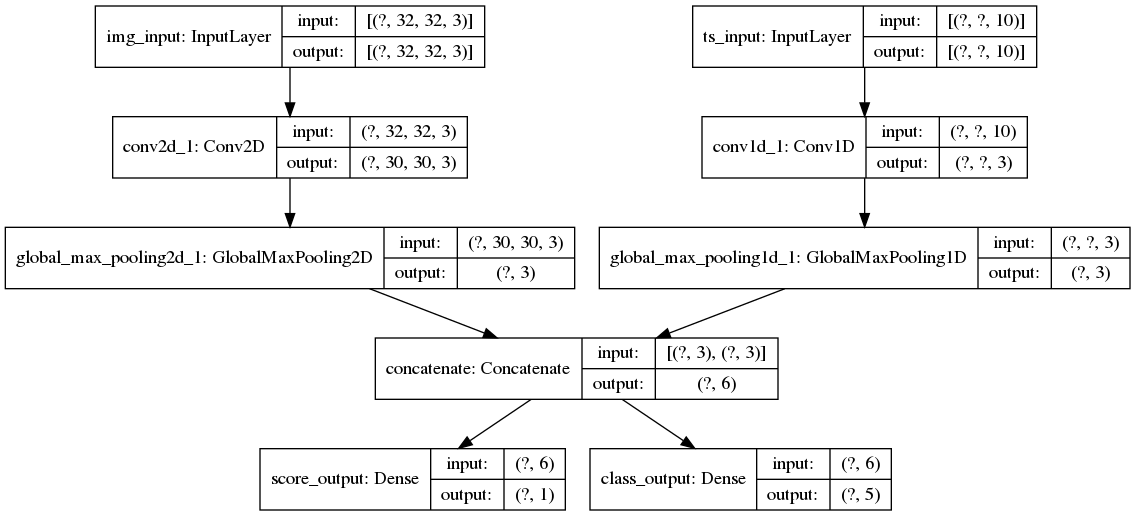

In [86]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

At compilation time, we can specify different losses to different outputs, by passing the loss functions as a list:

In [87]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy(from_logits=True)])

If we only passed a single loss function to the model, the same loss function would be applied to every output, which is not appropriate here.

Likewise for metrics:

In [88]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy(from_logits=True)],
    metrics=[[keras.metrics.MeanAbsolutePercentageError(),
              keras.metrics.MeanAbsoluteError()],
             [keras.metrics.CategoricalAccuracy()]])